In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftshift
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import pickle
from copy import copy
%matplotlib inline

In [2]:
with open('data_set_1.pkl', 'rb') as f:
    data_set_1 = pickle.load(f)

xvals1 = data_set_1[:, 0]
yvals1 = data_set_1[:, 1]

In [3]:
def xp_mat_maker(xvals, p):
    xp = np.ones((xvals.size, p+1))
    for jj in range(p):
        xp[:, jj+1] = xvals * xp[:, jj]
    return xp

In [4]:
def least_squares_solve(mat, yvals):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    alpha = (vt.T @ np.diag(1./s) @ u.T) @ yvals.reshape(-1, 1)
    error = np.linalg.norm(mat @ alpha - yvals.reshape(-1, 1))**2./(2.*yvals.size)
    return alpha, error 

In [29]:
def cross_fold(alpha, xvals, yvals, pval, kfolds):
    inds = np.arange(yvals.size)
    alpha_avg = np.zeros(pval+1)
    np.random.shuffle(inds)
    train_range = yvals[inds]
    train_domain = xvals[inds]
    bucket_size = int(np.floor(yvals.size/kfolds))
    for jj in range(kfolds):
        if jj == 0:
            bvec_train = train_range[bucket_size:]
            xvec_train = train_domain[bucket_size:]
        elif jj == kfolds - 1:
            bvec_train = train_range[-bucket_size:]
            xvec_train = train_domain[-bucket_size:]
        else:
            bvec_train = np.concatenate((train_range[:jj*bucket_size], train_range[(jj+1)*bucket_size:]))
            xvec_train = np.concatenate((train_domain[:jj*bucket_size], train_domain[(jj+1)*bucket_size:]))
            
        xp_train = xp_mat_maker(xvec_train, pval)        
        res = Lasso(alpha, max_iter=8000).fit(xp_train, bvec_train) # alpha > 0
        alpha_lasso = res.coef_
        alpha_avg += alpha_lasso
    alpha_avg /= kfolds
    return alpha_avg
    
def error_testing(alpha, xvals, yvals, pval):    
    num_experiments = 1000    
    errors = np.zeros(num_experiments)        
    inds = np.arange(yvals.size)
    expsize = round(.1*yvals.size)
    for jj in range(num_experiments):
        np.random.shuffle(inds)
        shuffle_range = yvals[inds]
        bvec = shuffle_range[:expsize].reshape(-1,1)
        shuffle_domain = xvals[inds]
        xp = xp_mat_maker(shuffle_domain[:expsize], pval)
        errors[jj] = np.linalg.norm(xp@alpha.reshape(-1, 1) - bvec)     
    mean_err = np.mean(errors)
    stand_dev = np.std(errors)
    return mean_err, stand_dev

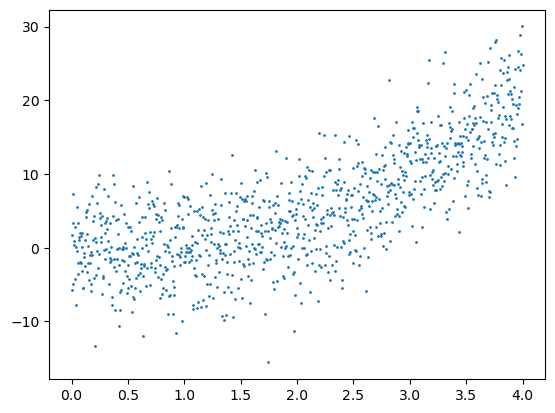

In [30]:
plt.scatter(xvals1, yvals1, s=1.)

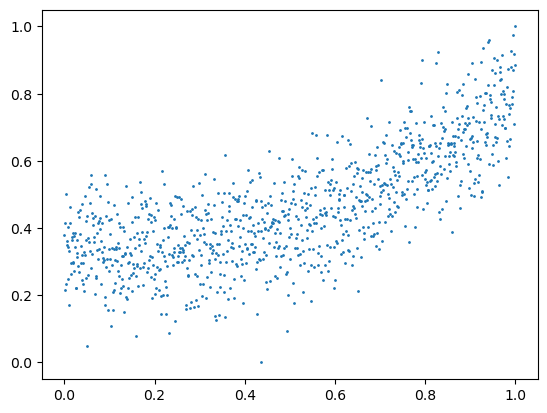

In [31]:
# rescale data
xmax = np.max(xvals1)
ymax = np.max(yvals1)
ymin = np.min(yvals1)
xvalsrsc = xvals1/xmax
yvalsrsc = (yvals1-ymin)/(ymax-ymin)
plt.scatter(xvalsrsc, yvalsrsc, s=1.)

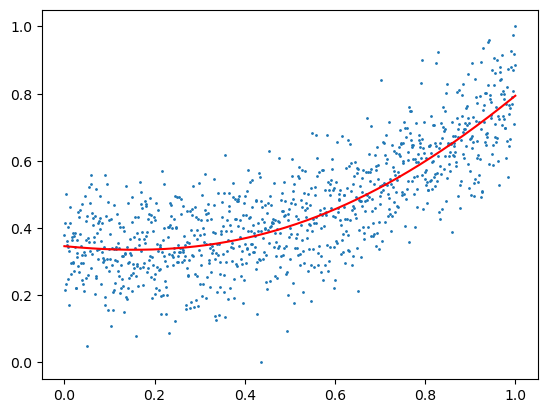

In [32]:
pval = 4
xp = xp_mat_maker(xvalsrsc, pval)
alpha, error = least_squares_solve(xp, yvalsrsc)
yfit = xp @ alpha.reshape(-1,1)
plt.plot(xvalsrsc, yfit, color='r')
plt.scatter(xvalsrsc, yvalsrsc, s=1.)

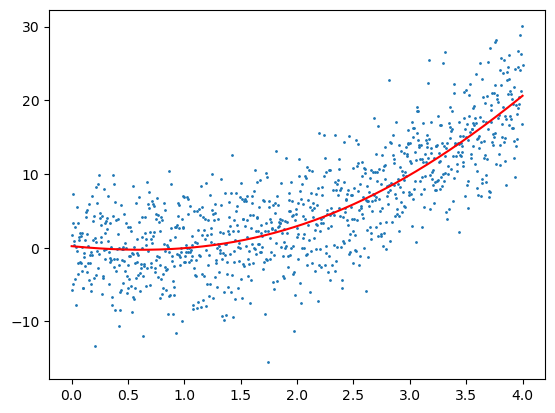

In [33]:
yfit = (ymax-ymin)*yfit + ymin
plt.plot(xvals1,yfit,color='r')
plt.scatter(xvals1, yvals1, s=1.)

In [37]:
numlams = 30
lampows = np.linspace(-5., -1., numlams) # choices, choices
errors = np.zeros(lampows.size)
stds = np.zeros(lampows.size)
pval = 10
kfolds = 10
train_size = round(.9*yvalsrsc.size)
avalsvslam = np.zeros((pval+1, numlams))
xtrain = xvalsrsc[:train_size]
ytrain = yvalsrsc[:train_size]
xtest = xvalsrsc[train_size:]
ytest = yvalsrsc[train_size:]
    
for jj, lampow in enumerate(lampows):
    lam = 10**(lampow)
    
    alpha_avg = cross_fold(lam, xtrain, ytrain, pval, kfolds)
    mean, std = error_testing(alpha_avg, xtest, ytest, pval) # alpha = 10^pow
    avalsvslam[:, jj] = alpha_avg
    errors[jj] = mean
    stds[jj] = std

/home/ccurtis/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-03, tolerance: 1.777e-03
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.322e-02, tolerance: 1.806e-03
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Text(0, 0.5, 'Mean Error')

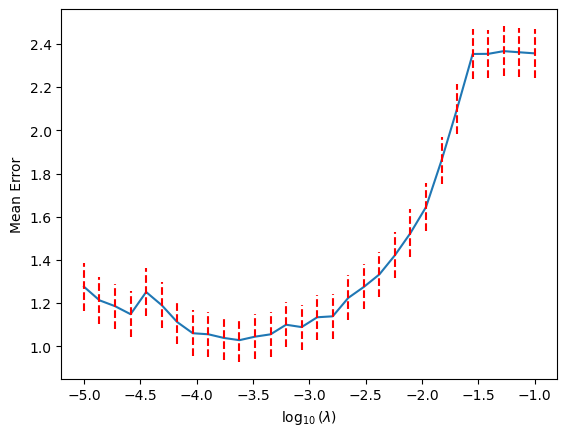

In [38]:
plt.plot(lampows, errors) # how would you plot the standard devations as error bars around the mean of the error?
for jj in range(stds.size):
    ejp = errors[jj] + stds[jj]
    ejm = errors[jj] - stds[jj]
    plt.plot([lampows[jj], lampows[jj]], [ejm, ejp], ls='--', c='r')
plt.xlabel(r"$\log_{10}(\lambda)$");
plt.ylabel(r"Mean Error")

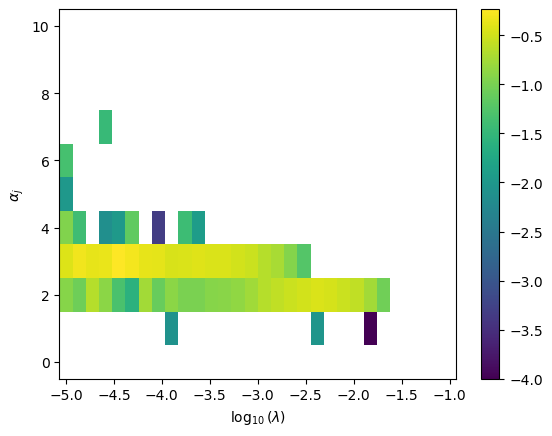

In [39]:
cfig = plt.pcolormesh(lampows, np.arange(pval+1), np.ma.log10(avalsvslam))
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel(r"$\alpha_{j}$")
plt.colorbar(cfig);